## Background explanation to go here!

In [5]:
using Pkg
Pkg.add("Turing")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [6]:
Pkg.add("Flux")
Pkg.add("Plots")
Pkg.add("Random")

 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]


In [7]:
using Turing, Flux, Plots, Random

In [9]:
# Hide sampling progress
Turing.turnprogress(false);

# Use reverse_diff due to the number of parameters in the neural network
Turing.setadbackend(:reverse_diff);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /home/lpaehler/.julia/packages/Turing/LONxt/src/Turing.jl:25


# 1. A First Bayesian Neural Network

In [14]:
# Number of points
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all data for later use
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)];

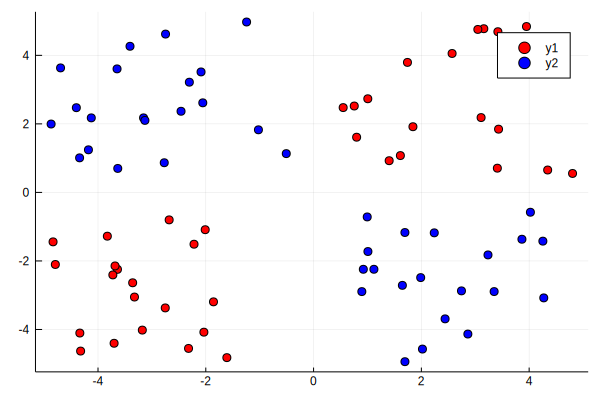

In [15]:
# Plot data points
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)
    
    Plots.scatter(x1, y1, color="red", clim = (0, 1))
    Plots.scatter!(x2, y2, color="blue", clim = (0, 1))
end

plot_data()

### Create a neural network with two hidden layers and one output layer

In [19]:
# Turn a vector into a set of weights and biases
function unpack(nn_params::AbstractVector)
    W1 = reshape(nn_params[1:6], 3, 2);
    b1 = reshape(nn_params[7:9], 3)
    
    W2 = reshape(nn_params[10:15], 2, 3);
    b2 = reshape(nn_params[16:17], 2)
    
    W0 = reshape(nn_params[18:19], 1, 2);
    b0 = reshape(nn_params[20:20], 1)
    return W1, b1, W2, b2, W0, b0
end

# Construct the neural network with Flux and predict its output
function nn_forward(xs, nn_params::AbstractVector)
    W1, b1, W2, b2, W0, b0 = unpack(nn_params)
    nn = Chain(Dense(W1, b1, tanh),
               Dense(W2, b2, tanh),
               Dense(W0, b0, σ))
    return nn(xs)
end;

### Build the probabilistic model

In [20]:
# Create a regularization term and a Gaussian prior variance term
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabilistic model
@model bayes_nn(xs, ts) = begin
    # Create the weight and bias vector
    nn_params ~ MvNormal(zeros(20), sig .* ones(20))
    
    # Calculate predictions for the inputs given the weights and biases in theta
    preds = nn_forward(xs, nn_params)
    
    # Observe each prediction
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

In [21]:
# Perform inference on the Bayesian neural network
N = 5000
ch = sample(bayes_nn(hcat(xs...), ts), HMC(0.05, 4), N);

In [22]:
# Extract weights and biases
theta = ch[:nn_params].value.data;

### Maximum a posteriori (MAP) estimation

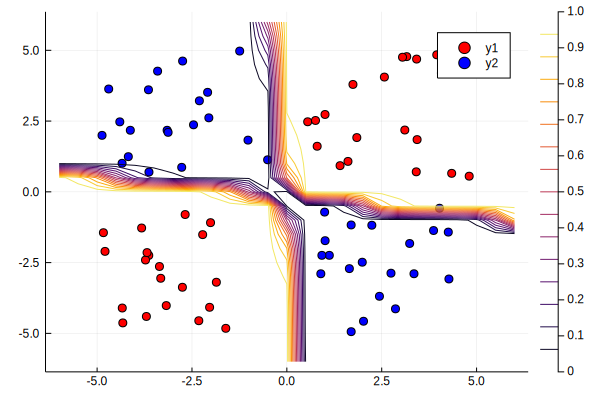

In [23]:
plot_data()

# Find index with highest log posterior in the chain
_, i = findmax(ch[:lp].value.data)

# Extract max row value
i = i.I[1]

# Plot posterior distribution
x_range = collect(range(-6, stop=6, length=25))
y_range = collect(range(-6, stop=6, length=25))
Z = [nn_forward([x, y], theta[i, :])[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

In [24]:
# Return average predicted value across weights
function nn_predict(x, theta, num)
    mean([nn_forward(x, theta[i, :])[1] for i in 1:10:num])
end;

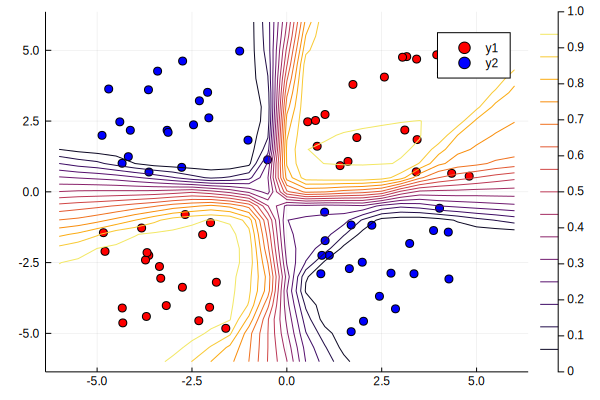

In [25]:
# Plot average prediction
plot_data()

n_end = 1500
x_range = collect(range(-6, stop=6, length=25))
y_range = collect(range(-6, stop=6, length=25))
Z = [nn_predict([x, y], theta, n_end)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

┌ Info: Saved animation to 
│   fn = /tmp/jl_ozeq2f.gif
└ @ Plots /home/lpaehler/.julia/packages/Plots/qZHsp/src/animation.jl:98


Plots.AnimatedGif("/tmp/jl_ozeq2f.gif")
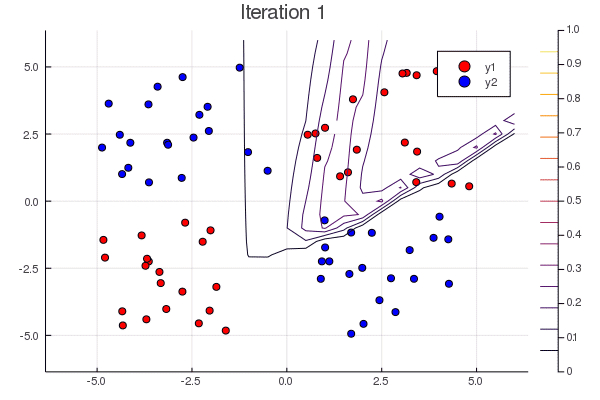

In [36]:
# Plot the evolution of the network's predictive power
n_end = 500

anim = @animate for i=1:n_end
    plot_data()
    Z = [nn_forward([x, y], theta[i, :])[1] for x=x_range, y=y_range]
    contour!(x_range, y_range, Z, title="Iteration $i", clim=(0, 1))
end every 5

gif(anim, "/tmp/jl_ozeq2f.gif", fps=15)

# 2. Generic Bayesian Neural Networks

## 2.1 More generalized framework

In [41]:
# Specify the network architecture made up of 'dense' layers
network_shape = [
    (3, 2, :tanh),
    (2, 3, :tanh),
    (1, 2, :σ)
]

# Regularization, parameter variance & total number of parameters
alpha = 0.09
sig = sqrt(1.0 / alpha)
num_params = sum([i * o + i for (i, o, _) in network_shape])

# Generate a series of vectors given the network shape
function unpack(θ::AbstractVector, network_shape::AbstractVector)
    index = 1
    weights = []
    biases = []
    for layer in network_shape
        rows, cols, _ = layer
        size = rows * cols
        last_index_w = size + index - 1
        last_index_b = last_index_w + rows
        push!(weights, reshape(θ[index:last_index_w], rows, cols))
        push!(biases, reshape(θ[last_index_w + 1:last_index_b], rows))
        index = last_index_b + 1
    end
    return weights, biases
end

# Generate the neural network given a shape and return a prediction
function nn_forward(x, θ::AbstractVector, network_shape::AbstractVector)
    weights, biases = unpack(θ, network_shape)
    layers = []
    for i in eachindex(network_shape)
        push!(layers, Dense(weights[i],
                biases[i],
                eval(network_shape[i][3])))
    end
    nn = Chain(layers...)
    return nn(x)
end

# General Turing specification for a BNN
@model bayes_nn(xs, ts, network_shape, num_params) = begin
    θ ~ MvNormal(zeros(num_params), sig .* ones(num_params))
    preds = nn_forward(xs, θ, network_shape)
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end

# Set the backend
Turing.setadbackend(:reverse_diff);

In [51]:
# Perform inference
num_samples = 10000
ch2 = sample(bayes_nn(hcat(xs...), ts, network_shape, num_params), HMC(0.05, 4), num_samples);

In [52]:
# Make predictions based on network shape
function nn_predict(x, theta, num, network_shape)
    mean([nn_forward(x, theta[i, :], network_shape)[1] for i in 1:10:num])
end;

# Extract θ from the sampled chain
params2 = ch2[:θ].value.data;

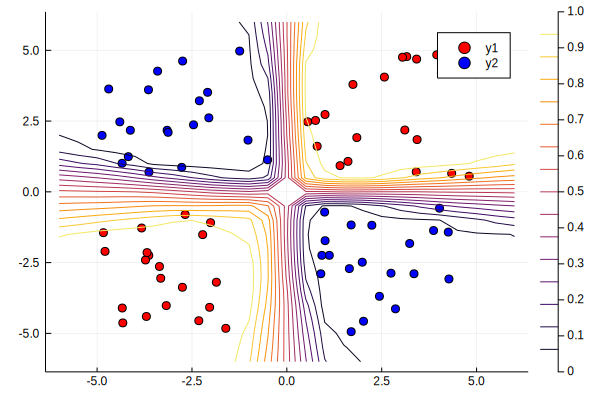

In [53]:
# Plot the prediction
plot_data()

x_range = collect(range(-6, stop=6, length=25))
y_range = collect(range(-6, stop=6, length=25))
Z = [nn_predict([x, y], params2, length(ch2), network_shape)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

# 3. Experiment with different types of Bayesian neural networks

In [ ]:
# Questions to be written down

In [54]:
# I.e. play around with differently configured networks and compare the amount of samples needed to
#   arrive at an expressive posterior.

# 4. Applying variational inference to generic Bayesian neural networks